## DataGeneration class 를 이용한 Diabetes 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

np.random.seed(0)

In [2]:
# 수치미분 함수

def numerical_derivative(f, x):
    delta_x = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:
        idx = it.multi_index        
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + delta_x
        fx1 = f(x) # f(x+delta_x)
        
        x[idx] = tmp_val - delta_x 
        fx2 = f(x) # f(x-delta_x)
        grad[idx] = (fx1 - fx2) / (2*delta_x)
        
        x[idx] = tmp_val 
        it.iternext()   
        
    return grad

# sigmoid 함수

def sigmoid(x):
    return 1 / (1+np.exp(-x))

#### Diabetes class 구현

In [3]:
# Diabetes Class

class Diabetes:
    
    # 생성자
    # xdata, tdata => numpy.array(...)
    def __init__(self, name, input_nodes, hidden1_nodes, output_nodes, learning_rate):
        
        self.name = name
        
        # 2층 hidden layer unit 
        # 가중치 W, 바이어스 b 초기화
        self.W2 = np.random.rand(input_nodes, hidden1_nodes)  
        self.b2 = np.random.rand(hidden1_nodes)
        
        # 3층 hidden layer unit  
        self.W3 = np.random.rand(hidden1_nodes, output_nodes)
        self.b3 = np.random.rand(output_nodes)
        
        # 학습률 learning rate 초기화
        self.learning_rate = learning_rate
        
        print(self.name, " is created !!!")
        
    # 손실함수
    def feed_forward(self):
        
        delta = 1e-7    # log 무한대 발산 방지
    
        z2 = np.dot(self.input_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        y = a3 = sigmoid(z3)
    
        # cross-entropy 
        return  -np.sum( self.target_data*np.log(y + delta) + (1-self.target_data)*np.log((1 - y)+delta ) )
    
    # 손실 값 계산
    def loss_val(self):
        
        delta = 1e-7    # log 무한대 발산 방지
    
        z2 = np.dot(self.input_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        y = a3 = sigmoid(z3)
            
        # cross-entropy 
        return  -np.sum( self.target_data*np.log(y + delta) + (1-self.target_data)*np.log((1 - y)+delta ) )
    
    # query, 즉 미래 값 예측 함수
    def predict(self, input_data):    
        
        z2 = np.dot(input_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        z3 = np.dot(a2, self.W3) + self.b3
        y = a3 = sigmoid(z3)
        
        if y >= 0.5:
            result = 1  # True
        else:
            result = 0  # False
    
        return y, result
    
    def accuracy(self, input_data, target_data):
        
        matched_list = []
        not_matched_list = []
        
        for index in range(len(input_data)):
            
            (real_val, logical_val) = self.predict(input_data[index])
            
            if logical_val == target_data[index]:
                matched_list.append(index)
            else:
                not_matched_list.append(index)
                
        accuracy_result = len(matched_list) / len(input_data)
        
        #print("Accuracy => ", accuracy_result)
        
        return not_matched_list, accuracy_result
        
        
    # 수치미분을 이용하여 손실함수가 최소가 될때 까지 학습하는 함수
    def train(self, input_data, target_data):
        
        self.input_data = input_data
        self.target_data = target_data
        
        f = lambda x : self.feed_forward()
        
        self.W2 -= self.learning_rate * numerical_derivative(f, self.W2)
    
        self.b2 -= self.learning_rate * numerical_derivative(f, self.b2)
        
        self.W3 -= self.learning_rate * numerical_derivative(f, self.W3)
    
        self.b3 -= self.learning_rate * numerical_derivative(f, self.b3)

#### DataGeneration class 구현

In [4]:
class DataGeneration:
    
    # target_position = 0 (첫번째열이 정답데이터), target_position=-1 (마지막열이 정답데이터)
    def __init__(self, name, file_path, seperation_rate, target_position=-1):
        
        self.name = name
        
        self.file_path = file_path
        
        self.seperation_rate = seperation_rate
        
        if (target_position == -1  or  target_position == 0):      
            self.target_position = target_position
        
        else:
            err_str = 'target_position must be -1 or 0'            
            raise Exception(err_str)    
            
    
    # print data target distribution 
    # str_of_kind : 'original data' or  'training data'  or  'test data'
    def __display_target_distribution(self, data, str_of_kind='original data'):
        
        print('=======================================================================================================')
        
        target_data = data[ :, self.target_position ]
        
        # numpy.unique() 사용하여 loaded data target 분포 확인
        unique, counts = np.unique(target_data, return_counts=True)

        unique_target = []
    
        for index in range(len(unique)):
        
            print('[DataGeneration] unique number of ' + str_of_kind + ' = ', unique[index], ', count = ', counts[index])
        
            unique_target.append(unique[index])

        for index in range(len(unique_target)):
        
            print('[DataGeneration] unique number of ' + str_of_kind + ' = ', unique_target[index], ', ratio = ', np.round(100 * counts[index] / (target_data.shape[0]), 2), ' %')
    
        print('=======================================================================================================')
        
        
    # numpy.random.shuffle()  이용하여 training_data / test_data 생성
    def generate(self):
    
        # 데이터 불러오기, 파일이 없는 경우 exception 발생

        try:
            loaded_data = np.loadtxt(self.file_path, delimiter=',', dtype=np.float32)
            
        except Exception as err:
            print('[DataGeneration::generate()]  ', str(err))
            raise Exception(str(err))

        print("[DataGeneration]  loaded_data.shape = ", loaded_data.shape)
            
        # print the target distribution of original data 
        
        self.__display_target_distribution(loaded_data, 'original data')
        
        
        # 분리비율에 맞게 테스트데이터로 분리
        total_data_num = len(loaded_data)
        test_data_num = int(len(loaded_data) * self.seperation_rate)

        # numpy.random.shuffle 을 이용하여 랜덤하게 데이터 섞기
        np.random.shuffle(loaded_data)
        
        # test_data 는 0 : test_data_num
        
        
        test_data = loaded_data[ 0:test_data_num ]

        # training_data 는 test_data_num 부터 끝까지 
        training_data = loaded_data[ test_data_num: ]

        # display target distribution of generated data 
        
        self.__display_target_distribution(training_data, 'training data')
        
        self.__display_target_distribution(test_data, 'test data')
        
        return training_data, test_data

### (분리비율 0.3)  DataGeneration 객체를 통한 training_data , test_data, validation_data  생성 

In [5]:
# DataGeneration 객체 생성.
test_seperation_rate = 0.3 # 테스트 데이터 분리비율

data_obj = DataGeneration('Diabetes', './(200309)Diabetes.csv', test_seperation_rate)

(training_data, test_data) = data_obj.generate()

print('================================================')
print('training data.shape = ', training_data.shape)
print('test data.shape = ', test_data.shape)
print('================================================')

[DataGeneration]  loaded_data.shape =  (759, 9)
[DataGeneration] unique number of original data =  0.0 , count =  263
[DataGeneration] unique number of original data =  1.0 , count =  496
[DataGeneration] unique number of original data =  0.0 , ratio =  34.65  %
[DataGeneration] unique number of original data =  1.0 , ratio =  65.35  %
[DataGeneration] unique number of training data =  0.0 , count =  180
[DataGeneration] unique number of training data =  1.0 , count =  352
[DataGeneration] unique number of training data =  0.0 , ratio =  33.83  %
[DataGeneration] unique number of training data =  1.0 , ratio =  66.17  %
[DataGeneration] unique number of test data =  0.0 , count =  83
[DataGeneration] unique number of test data =  1.0 , count =  144
[DataGeneration] unique number of test data =  0.0 , ratio =  36.56  %
[DataGeneration] unique number of test data =  1.0 , ratio =  63.44  %
training data.shape =  (532, 9)
test data.shape =  (227, 9)


In [6]:
#hyper-parameter
i_nodes = training_data.shape[1] - 1    # input nodes 개수
h1_nodes = 20  # hidden 1 nodes 개수. 
o_nodes = 1    # output nodes 개수
lr = 1e-2      # learning rate. hi_node = 2, 1e-1 에서 수렴
epochs = 20   # 반복횟수. 

# 저장 리스트
loss_val_list = []    # loss val list
accuracy_val_list = []    # training data accuracy val
validation_accuracy_val_list = []    # validation data loss val


# Diabetes 객체 생성
obj1 = Diabetes("Diabetes", i_nodes, h1_nodes, o_nodes, lr)

print("Neural Network Learning using Numerical Derivative...")

start_time = datetime.now()

for step in range(epochs):
    
    for index in range(len(training_data)):
        
        input_data = training_data[index, 0:-1]
        target_data = training_data[index, [-1]]
        
        obj1.train(input_data, target_data)
        
    cur_loss_val = obj1.loss_val()
    
    loss_val_list.append(cur_loss_val)
    
    (not_matched_list, training_accuracy) = obj1.accuracy(training_data[:, 0:-1], training_data[:, -1])
    
    (not_matched_list, validation_accuracy) = obj1.accuracy(test_data[:, 0:-1], test_data[:, -1])
    
    print('====================================================================')
    print("step = ", step, "            current loss value = ", cur_loss_val, '\n')
    print("step = ", step, "[training data] accuracy value = ", np.round(100*training_accuracy,4), ' %')
    
    accuracy_val_list.append(training_accuracy)
    
    print("step = ", step, "[validation data] accuracy value = ", np.round(100*validation_accuracy,4), ' %')
    
    validation_accuracy_val_list.append(validation_accuracy)

print('====================================================================')

end_time = datetime.now()
        
print("")
print("Elapsed Time => ", end_time - start_time)

Diabetes  is created !!!
Neural Network Learning using Numerical Derivative...
step =  0             current loss value =  0.9414158899995229 

step =  0 [training data] accuracy value =  65.7895  %
step =  0 [validation data] accuracy value =  63.4361  %
step =  1             current loss value =  0.9098947365887382 

step =  1 [training data] accuracy value =  66.1654  %
step =  1 [validation data] accuracy value =  63.4361  %
step =  2             current loss value =  0.8966728583448913 

step =  2 [training data] accuracy value =  66.1654  %
step =  2 [validation data] accuracy value =  63.4361  %
step =  3             current loss value =  0.8860055177348498 

step =  3 [training data] accuracy value =  65.9774  %
step =  3 [validation data] accuracy value =  64.3172  %
step =  4             current loss value =  0.8770481633736776 

step =  4 [training data] accuracy value =  67.6692  %
step =  4 [validation data] accuracy value =  68.2819  %
step =  5             current loss v

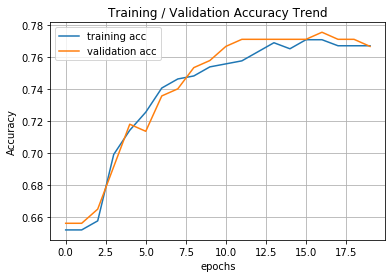

In [14]:
plt.title('Training / Validation Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(accuracy_val_list)
plt.plot(validation_accuracy_val_list)
plt.legend(['training acc', 'validation acc'])

plt.show()

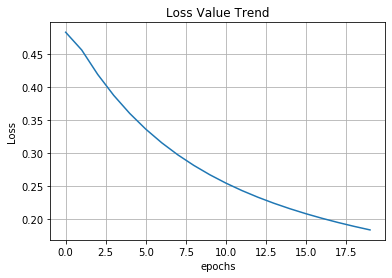

In [15]:
plt.title('Loss Value Trend')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.grid()
plt.plot(loss_val_list)

plt.show()

### (분리비율 0.5) DataGeneration 객체를 통한 training_data , test_data, validation_data  생성 

In [16]:
# DataGeneration 객체 생성.
test_seperation_rate = 0.5 # 테스트 데이터 분리비율

data_obj = DataGeneration('Diabetes', './(200309)Diabetes.csv', test_seperation_rate)

(training_data, test_data) = data_obj.generate()

print('================================================')
print('training data.shape = ', training_data.shape)
print('test data.shape = ', test_data.shape)
print('================================================')

[DataGeneration]  loaded_data.shape =  (759, 9)
[DataGeneration] unique number of original data =  0.0 , count =  263
[DataGeneration] unique number of original data =  1.0 , count =  496
[DataGeneration] unique number of original data =  0.0 , ratio =  34.65  %
[DataGeneration] unique number of original data =  1.0 , ratio =  65.35  %
[DataGeneration] unique number of training data =  0.0 , count =  130
[DataGeneration] unique number of training data =  1.0 , count =  250
[DataGeneration] unique number of training data =  0.0 , ratio =  34.21  %
[DataGeneration] unique number of training data =  1.0 , ratio =  65.79  %
[DataGeneration] unique number of test data =  0.0 , count =  133
[DataGeneration] unique number of test data =  1.0 , count =  246
[DataGeneration] unique number of test data =  0.0 , ratio =  35.09  %
[DataGeneration] unique number of test data =  1.0 , ratio =  64.91  %
training data.shape =  (380, 9)
test data.shape =  (379, 9)


In [17]:
#hyper-parameter
i_nodes = training_data.shape[1] - 1    # input nodes 개수
h1_nodes = 20  # hidden 1 nodes 개수. 
o_nodes = 1    # output nodes 개수
lr = 1e-2      # learning rate. hi_node = 2, 1e-1 에서 수렴
epochs = 20   # 반복횟수. 

# 저장 리스트
loss_val_list = []    # loss val list
accuracy_val_list = []    # training data accuracy val
validation_accuracy_val_list = []    # validation data loss val


# Diabetes 객체 생성
obj1 = Diabetes("Diabetes", i_nodes, h1_nodes, o_nodes, lr)

print("Neural Network Learning using Numerical Derivative...")

start_time = datetime.now()

for step in range(epochs):
    
    for index in range(len(training_data)):
        
        input_data = training_data[index, 0:-1]
        target_data = training_data[index, [-1]]
        
        obj1.train(input_data, target_data)
        
    cur_loss_val = obj1.loss_val()
    
    loss_val_list.append(cur_loss_val)
    
    (not_matched_list, training_accuracy) = obj1.accuracy(training_data[:, 0:-1], training_data[:, -1])
    
    (not_matched_list, validation_accuracy) = obj1.accuracy(test_data[:, 0:-1], test_data[:, -1])
    
    print('====================================================================')
    print("step = ", step, "            current loss value = ", cur_loss_val, '\n')
    print("step = ", step, "[training data] accuracy value = ", np.round(100*training_accuracy,4), ' %')
    
    accuracy_val_list.append(training_accuracy)
    
    print("step = ", step, "[validation data] accuracy value = ", np.round(100*validation_accuracy,4), ' %')
    
    validation_accuracy_val_list.append(validation_accuracy)

print('====================================================================')

end_time = datetime.now()
        
print("")
print("Elapsed Time => ", end_time - start_time)

Diabetes  is created !!!
Neural Network Learning using Numerical Derivative...
step =  0             current loss value =  0.3548602963770238 

step =  0 [training data] accuracy value =  65.7895  %
step =  0 [validation data] accuracy value =  64.9077  %
step =  1             current loss value =  0.44365605156588017 

step =  1 [training data] accuracy value =  65.7895  %
step =  1 [validation data] accuracy value =  64.9077  %
step =  2             current loss value =  0.43134747534169016 

step =  2 [training data] accuracy value =  65.7895  %
step =  2 [validation data] accuracy value =  64.9077  %
step =  3             current loss value =  0.4165969240328747 

step =  3 [training data] accuracy value =  65.7895  %
step =  3 [validation data] accuracy value =  64.9077  %
step =  4             current loss value =  0.4032614031180115 

step =  4 [training data] accuracy value =  66.0526  %
step =  4 [validation data] accuracy value =  64.9077  %
step =  5             current loss

### 손실함수가 최적화가 되지 않았기 때문에 정확도가 의미없지만,
### 아래의 정확도 그래프 자체만 해석해보면 training data 에 대해 overfitting 임을 알수 있음
### overfitting 이 어떻게 되는지 볼수있는 그래프임

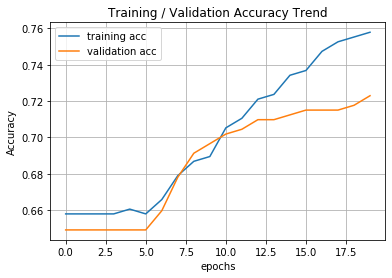

In [18]:
plt.title('Training / Validation Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(accuracy_val_list)
plt.plot(validation_accuracy_val_list)
plt.legend(['training acc', 'validation acc'])

plt.show()    

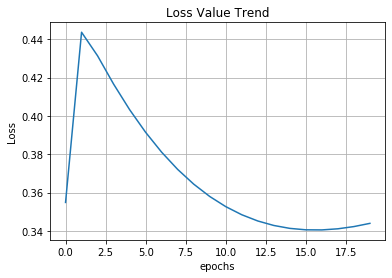

In [19]:
plt.title('Loss Value Trend')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.grid()
plt.plot(loss_val_list)

plt.show()

### (분리비율 0.2) DataGeneration 객체를 통한 training_data , test_data, validation_data  생성 

In [20]:
# DataGeneration 객체 생성.
test_seperation_rate = 0.2 # 테스트 데이터 분리비율

data_obj = DataGeneration('Diabetes', './(200309)Diabetes.csv', test_seperation_rate)

(training_data, test_data) = data_obj.generate()

print('================================================')
print('training data.shape = ', training_data.shape)
print('test data.shape = ', test_data.shape)
print('================================================')

[DataGeneration]  loaded_data.shape =  (759, 9)
[DataGeneration] unique number of original data =  0.0 , count =  263
[DataGeneration] unique number of original data =  1.0 , count =  496
[DataGeneration] unique number of original data =  0.0 , ratio =  34.65  %
[DataGeneration] unique number of original data =  1.0 , ratio =  65.35  %
[DataGeneration] unique number of training data =  0.0 , count =  209
[DataGeneration] unique number of training data =  1.0 , count =  399
[DataGeneration] unique number of training data =  0.0 , ratio =  34.38  %
[DataGeneration] unique number of training data =  1.0 , ratio =  65.62  %
[DataGeneration] unique number of test data =  0.0 , count =  54
[DataGeneration] unique number of test data =  1.0 , count =  97
[DataGeneration] unique number of test data =  0.0 , ratio =  35.76  %
[DataGeneration] unique number of test data =  1.0 , ratio =  64.24  %
training data.shape =  (608, 9)
test data.shape =  (151, 9)


In [21]:
#hyper-parameter
i_nodes = training_data.shape[1] - 1    # input nodes 개수
h1_nodes = 20  # hidden 1 nodes 개수. 
o_nodes = 1    # output nodes 개수
lr = 1e-2      # learning rate. hi_node = 2, 1e-1 에서 수렴
epochs = 20   # 반복횟수. 

# 저장 리스트
loss_val_list = []    # loss val list
accuracy_val_list = []    # training data accuracy val
validation_accuracy_val_list = []    # validation data loss val


# Diabetes 객체 생성
obj1 = Diabetes("Diabetes", i_nodes, h1_nodes, o_nodes, lr)

print("Neural Network Learning using Numerical Derivative...")

start_time = datetime.now()

for step in range(epochs):
    
    for index in range(len(training_data)):
        
        input_data = training_data[index, 0:-1]
        target_data = training_data[index, [-1]]
        
        obj1.train(input_data, target_data)
        
    cur_loss_val = obj1.loss_val()
    
    loss_val_list.append(cur_loss_val)
    
    (not_matched_list, training_accuracy) = obj1.accuracy(training_data[:, 0:-1], training_data[:, -1])
    
    (not_matched_list, validation_accuracy) = obj1.accuracy(test_data[:, 0:-1], test_data[:, -1])
    
    print('====================================================================')
    print("step = ", step, "            current loss value = ", cur_loss_val, '\n')
    print("step = ", step, "[training data] accuracy value = ", np.round(100*training_accuracy,4), ' %')
    
    accuracy_val_list.append(training_accuracy)
    
    print("step = ", step, "[validation data] accuracy value = ", np.round(100*validation_accuracy,4), ' %')
    
    validation_accuracy_val_list.append(validation_accuracy)

print('====================================================================')

end_time = datetime.now()
        
print("")
print("Elapsed Time => ", end_time - start_time)

Diabetes  is created !!!
Neural Network Learning using Numerical Derivative...
step =  0             current loss value =  0.7838521815173266 

step =  0 [training data] accuracy value =  47.8618  %
step =  0 [validation data] accuracy value =  47.0199  %
step =  1             current loss value =  0.6570942571579789 

step =  1 [training data] accuracy value =  65.625  %
step =  1 [validation data] accuracy value =  64.2384  %
step =  2             current loss value =  0.5533358754034654 

step =  2 [training data] accuracy value =  65.625  %
step =  2 [validation data] accuracy value =  64.2384  %
step =  3             current loss value =  0.47280136421929947 

step =  3 [training data] accuracy value =  65.7895  %
step =  3 [validation data] accuracy value =  64.2384  %
step =  4             current loss value =  0.4090730647288244 

step =  4 [training data] accuracy value =  66.2829  %
step =  4 [validation data] accuracy value =  64.9007  %
step =  5             current loss va

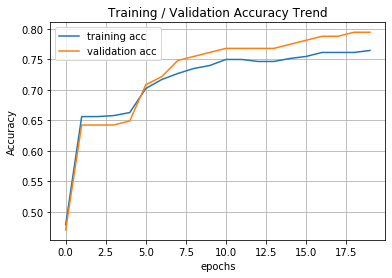

In [22]:
plt.title('Training / Validation Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(accuracy_val_list)
plt.plot(validation_accuracy_val_list)
plt.legend(['training acc', 'validation acc'])

plt.show()

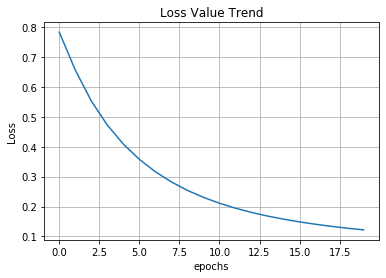

In [23]:
plt.title('Loss Value Trend')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.grid()
plt.plot(loss_val_list)

plt.show()

### (분리비율 0.6) DataGeneration 객체를 통한 training_data , test_data, validation_data  생성 

In [29]:
# DataGeneration 객체 생성.
test_seperation_rate = 0.6 # 테스트 데이터 분리비율

data_obj = DataGeneration('Diabetes', './(200309)Diabetes.csv', test_seperation_rate)

(training_data, test_data) = data_obj.generate()

print('================================================')
print('training data.shape = ', training_data.shape)
print('test data.shape = ', test_data.shape)
print('================================================')

[DataGeneration]  loaded_data.shape =  (759, 9)
[DataGeneration] unique number of original data =  0.0 , count =  263
[DataGeneration] unique number of original data =  1.0 , count =  496
[DataGeneration] unique number of original data =  0.0 , ratio =  34.65  %
[DataGeneration] unique number of original data =  1.0 , ratio =  65.35  %
[DataGeneration] unique number of training data =  0.0 , count =  106
[DataGeneration] unique number of training data =  1.0 , count =  198
[DataGeneration] unique number of training data =  0.0 , ratio =  34.87  %
[DataGeneration] unique number of training data =  1.0 , ratio =  65.13  %
[DataGeneration] unique number of test data =  0.0 , count =  157
[DataGeneration] unique number of test data =  1.0 , count =  298
[DataGeneration] unique number of test data =  0.0 , ratio =  34.51  %
[DataGeneration] unique number of test data =  1.0 , ratio =  65.49  %
training data.shape =  (304, 9)
test data.shape =  (455, 9)


In [30]:
#hyper-parameter
i_nodes = training_data.shape[1] - 1    # input nodes 개수
h1_nodes = 20  # hidden 1 nodes 개수. 
o_nodes = 1    # output nodes 개수
lr = 1e-2      # learning rate. hi_node = 2, 1e-1 에서 수렴
epochs = 20   # 반복횟수. 

# 저장 리스트
loss_val_list = []    # loss val list
accuracy_val_list = []    # training data accuracy val
validation_accuracy_val_list = []    # validation data loss val


# Diabetes 객체 생성
obj1 = Diabetes("Diabetes", i_nodes, h1_nodes, o_nodes, lr)

print("Neural Network Learning using Numerical Derivative...")

start_time = datetime.now()

for step in range(epochs):
    
    for index in range(len(training_data)):
        
        input_data = training_data[index, 0:-1]
        target_data = training_data[index, [-1]]
        
        obj1.train(input_data, target_data)
        
    cur_loss_val = obj1.loss_val()
    
    loss_val_list.append(cur_loss_val)
    
    (not_matched_list, training_accuracy) = obj1.accuracy(training_data[:, 0:-1], training_data[:, -1])
    
    (not_matched_list, validation_accuracy) = obj1.accuracy(test_data[:, 0:-1], test_data[:, -1])
    
    print('====================================================================')
    print("step = ", step, "            current loss value = ", cur_loss_val, '\n')
    print("step = ", step, "[training data] accuracy value = ", np.round(100*training_accuracy,4), ' %')
    
    accuracy_val_list.append(training_accuracy)
    
    print("step = ", step, "[validation data] accuracy value = ", np.round(100*validation_accuracy,4), ' %')
    
    validation_accuracy_val_list.append(validation_accuracy)

print('====================================================================')

end_time = datetime.now()
        
print("")
print("Elapsed Time => ", end_time - start_time)

Diabetes  is created !!!
Neural Network Learning using Numerical Derivative...
step =  0             current loss value =  0.5713921980530778 

step =  0 [training data] accuracy value =  65.1316  %
step =  0 [validation data] accuracy value =  65.4945  %
step =  1             current loss value =  0.6336120195752633 

step =  1 [training data] accuracy value =  65.1316  %
step =  1 [validation data] accuracy value =  65.2747  %
step =  2             current loss value =  0.5845123466002341 

step =  2 [training data] accuracy value =  64.8026  %
step =  2 [validation data] accuracy value =  65.4945  %
step =  3             current loss value =  0.5380219035739647 

step =  3 [training data] accuracy value =  65.1316  %
step =  3 [validation data] accuracy value =  65.4945  %
step =  4             current loss value =  0.4971792677276911 

step =  4 [training data] accuracy value =  65.1316  %
step =  4 [validation data] accuracy value =  65.4945  %
step =  5             current loss v

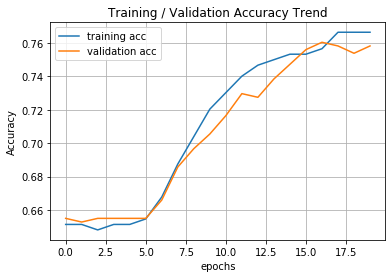

In [31]:
plt.title('Training / Validation Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(accuracy_val_list)
plt.plot(validation_accuracy_val_list)
plt.legend(['training acc', 'validation acc'])

plt.show()

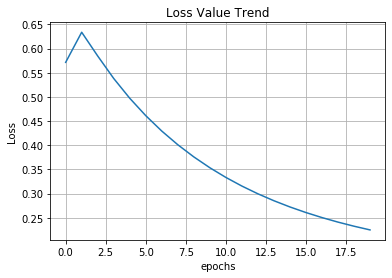

In [32]:
plt.title('Loss Value Trend')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.grid()
plt.plot(loss_val_list)

plt.show()

### (분리비율 0.1) DataGeneration 객체를 통한 training_data , test_data, validation_data  생성 

In [33]:
# DataGeneration 객체 생성.
test_seperation_rate = 0.1 # 테스트 데이터 분리비율

data_obj = DataGeneration('Diabetes', './(200309)Diabetes.csv', test_seperation_rate)

(training_data, test_data) = data_obj.generate()

print('================================================')
print('training data.shape = ', training_data.shape)
print('test data.shape = ', test_data.shape)
print('================================================')

[DataGeneration]  loaded_data.shape =  (759, 9)
[DataGeneration] unique number of original data =  0.0 , count =  263
[DataGeneration] unique number of original data =  1.0 , count =  496
[DataGeneration] unique number of original data =  0.0 , ratio =  34.65  %
[DataGeneration] unique number of original data =  1.0 , ratio =  65.35  %
[DataGeneration] unique number of training data =  0.0 , count =  236
[DataGeneration] unique number of training data =  1.0 , count =  448
[DataGeneration] unique number of training data =  0.0 , ratio =  34.5  %
[DataGeneration] unique number of training data =  1.0 , ratio =  65.5  %
[DataGeneration] unique number of test data =  0.0 , count =  27
[DataGeneration] unique number of test data =  1.0 , count =  48
[DataGeneration] unique number of test data =  0.0 , ratio =  36.0  %
[DataGeneration] unique number of test data =  1.0 , ratio =  64.0  %
training data.shape =  (684, 9)
test data.shape =  (75, 9)


In [34]:
#hyper-parameter
i_nodes = training_data.shape[1] - 1    # input nodes 개수
h1_nodes = 20  # hidden 1 nodes 개수. 
o_nodes = 1    # output nodes 개수
lr = 1e-2      # learning rate. hi_node = 2, 1e-1 에서 수렴
epochs = 20   # 반복횟수. 

# 저장 리스트
loss_val_list = []    # loss val list
accuracy_val_list = []    # training data accuracy val
validation_accuracy_val_list = []    # validation data loss val


# Diabetes 객체 생성
obj1 = Diabetes("Diabetes", i_nodes, h1_nodes, o_nodes, lr)

print("Neural Network Learning using Numerical Derivative...")

start_time = datetime.now()

for step in range(epochs):
    
    for index in range(len(training_data)):
        
        input_data = training_data[index, 0:-1]
        target_data = training_data[index, [-1]]
        
        obj1.train(input_data, target_data)
        
    cur_loss_val = obj1.loss_val()
    
    loss_val_list.append(cur_loss_val)
    
    (not_matched_list, training_accuracy) = obj1.accuracy(training_data[:, 0:-1], training_data[:, -1])
    
    (not_matched_list, validation_accuracy) = obj1.accuracy(test_data[:, 0:-1], test_data[:, -1])
    
    print('====================================================================')
    print("step = ", step, "            current loss value = ", cur_loss_val, '\n')
    print("step = ", step, "[training data] accuracy value = ", np.round(100*training_accuracy,4), ' %')
    
    accuracy_val_list.append(training_accuracy)
    
    print("step = ", step, "[validation data] accuracy value = ", np.round(100*validation_accuracy,4), ' %')
    
    validation_accuracy_val_list.append(validation_accuracy)

print('====================================================================')

end_time = datetime.now()
        
print("")
print("Elapsed Time => ", end_time - start_time)

Diabetes  is created !!!
Neural Network Learning using Numerical Derivative...
step =  0             current loss value =  0.6665064605026889 

step =  0 [training data] accuracy value =  65.4971  %
step =  0 [validation data] accuracy value =  64.0  %
step =  1             current loss value =  0.5432776703129173 

step =  1 [training data] accuracy value =  65.4971  %
step =  1 [validation data] accuracy value =  64.0  %
step =  2             current loss value =  0.4490048938497267 

step =  2 [training data] accuracy value =  65.3509  %
step =  2 [validation data] accuracy value =  65.3333  %
step =  3             current loss value =  0.37676093780578657 

step =  3 [training data] accuracy value =  69.0058  %
step =  3 [validation data] accuracy value =  66.6667  %
step =  4             current loss value =  0.32119557766764856 

step =  4 [training data] accuracy value =  71.6374  %
step =  4 [validation data] accuracy value =  68.0  %
step =  5             current loss value = 

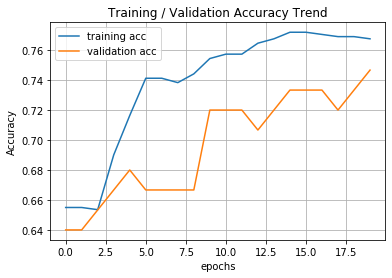

In [35]:
plt.title('Training / Validation Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(accuracy_val_list)
plt.plot(validation_accuracy_val_list)
plt.legend(['training acc', 'validation acc'])

plt.show()

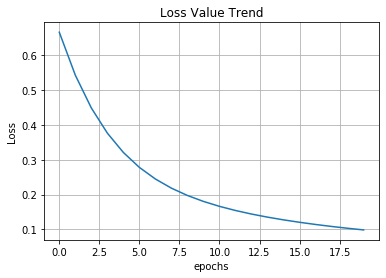

In [36]:
plt.title('Loss Value Trend')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.grid()
plt.plot(loss_val_list)

plt.show()

### (분리비율 0.9) DataGeneration 객체를 통한 training_data , test_data, validation_data  생성 

In [37]:
# DataGeneration 객체 생성.
test_seperation_rate = 0.9 # 테스트 데이터 분리비율

data_obj = DataGeneration('Diabetes', './(200309)Diabetes.csv', test_seperation_rate)

(training_data, test_data) = data_obj.generate()

print('================================================')
print('training data.shape = ', training_data.shape)
print('test data.shape = ', test_data.shape)
print('================================================')

[DataGeneration]  loaded_data.shape =  (759, 9)
[DataGeneration] unique number of original data =  0.0 , count =  263
[DataGeneration] unique number of original data =  1.0 , count =  496
[DataGeneration] unique number of original data =  0.0 , ratio =  34.65  %
[DataGeneration] unique number of original data =  1.0 , ratio =  65.35  %
[DataGeneration] unique number of training data =  0.0 , count =  21
[DataGeneration] unique number of training data =  1.0 , count =  55
[DataGeneration] unique number of training data =  0.0 , ratio =  27.63  %
[DataGeneration] unique number of training data =  1.0 , ratio =  72.37  %
[DataGeneration] unique number of test data =  0.0 , count =  242
[DataGeneration] unique number of test data =  1.0 , count =  441
[DataGeneration] unique number of test data =  0.0 , ratio =  35.43  %
[DataGeneration] unique number of test data =  1.0 , ratio =  64.57  %
training data.shape =  (76, 9)
test data.shape =  (683, 9)


In [38]:
#hyper-parameter
i_nodes = training_data.shape[1] - 1    # input nodes 개수
h1_nodes = 20  # hidden 1 nodes 개수. 
o_nodes = 1    # output nodes 개수
lr = 1e-2      # learning rate. hi_node = 2, 1e-1 에서 수렴
epochs = 20   # 반복횟수. 

# 저장 리스트
loss_val_list = []    # loss val list
accuracy_val_list = []    # training data accuracy val
validation_accuracy_val_list = []    # validation data loss val


# Diabetes 객체 생성
obj1 = Diabetes("Diabetes", i_nodes, h1_nodes, o_nodes, lr)

print("Neural Network Learning using Numerical Derivative...")

start_time = datetime.now()

for step in range(epochs):
    
    for index in range(len(training_data)):
        
        input_data = training_data[index, 0:-1]
        target_data = training_data[index, [-1]]
        
        obj1.train(input_data, target_data)
        
    cur_loss_val = obj1.loss_val()
    
    loss_val_list.append(cur_loss_val)
    
    (not_matched_list, training_accuracy) = obj1.accuracy(training_data[:, 0:-1], training_data[:, -1])
    
    (not_matched_list, validation_accuracy) = obj1.accuracy(test_data[:, 0:-1], test_data[:, -1])
    
    print('====================================================================')
    print("step = ", step, "            current loss value = ", cur_loss_val, '\n')
    print("step = ", step, "[training data] accuracy value = ", np.round(100*training_accuracy,4), ' %')
    
    accuracy_val_list.append(training_accuracy)
    
    print("step = ", step, "[validation data] accuracy value = ", np.round(100*validation_accuracy,4), ' %')
    
    validation_accuracy_val_list.append(validation_accuracy)

print('====================================================================')

end_time = datetime.now()
        
print("")
print("Elapsed Time => ", end_time - start_time)

Diabetes  is created !!!
Neural Network Learning using Numerical Derivative...
step =  0             current loss value =  0.009915838921101794 

step =  0 [training data] accuracy value =  72.3684  %
step =  0 [validation data] accuracy value =  64.5681  %
step =  1             current loss value =  0.03519877343814953 

step =  1 [training data] accuracy value =  72.3684  %
step =  1 [validation data] accuracy value =  64.5681  %
step =  2             current loss value =  0.09500880680853786 

step =  2 [training data] accuracy value =  72.3684  %
step =  2 [validation data] accuracy value =  64.5681  %
step =  3             current loss value =  0.18220150939491211 

step =  3 [training data] accuracy value =  72.3684  %
step =  3 [validation data] accuracy value =  64.5681  %
step =  4             current loss value =  0.26013817783369464 

step =  4 [training data] accuracy value =  72.3684  %
step =  4 [validation data] accuracy value =  64.5681  %
step =  5             current 

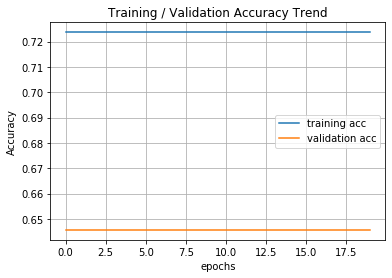

In [39]:
plt.title('Training / Validation Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(accuracy_val_list)
plt.plot(validation_accuracy_val_list)
plt.legend(['training acc', 'validation acc'])

plt.show()

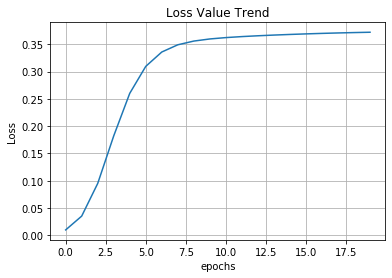

In [40]:
plt.title('Loss Value Trend')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.grid()
plt.plot(loss_val_list)

plt.show()